# Detecting Influential Observations

In [2]:
# import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import influence_plot

In [3]:
# set random seed
np.random.seed()

# generate random data
n = 100
X = np.random.normal(0, 1, n)

# create a linear relationship with some noise
y = 2 + 3 * X + np.random.normal(0, 1, n)

In [4]:
# create dataframe
df = pd.DataFrame({
    'X': X,
    'y': y
})

In [ ]:
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['y'])
plt.title("Scatter Plot of Data with Influential Point")
plt.xlabel("X")
plt.ylabel("y")
# plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# add one influential point
df.loc[100] = [4, 20] # high leverage and outlier

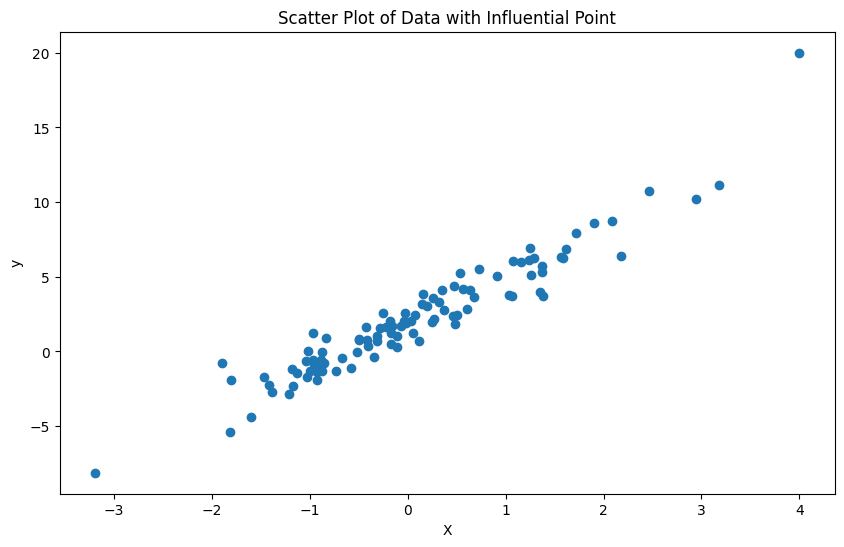

In [6]:
# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(df['X'], df['y'])
plt.title("Scatter Plot of Data with Influential Point")
plt.xlabel("X")
plt.ylabel("y")
# plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# add constant (intercept) to the model
X_with_const = sm.add_constant(df["X"])

In [8]:
# fit model
model = sm.OLS(df['y'], X_with_const).fit()

In [9]:
# print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     1067.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           8.08e-55
Time:                        00:37:04   Log-Likelihood:                -154.65
No. Observations:                 101   AIC:                             313.3
Df Residuals:                      99   BIC:                             318.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9642      0.113     17.441      0.0

### Residual Analysis

In [10]:
# calculate residuals
df['residuals'] = model.resid
df['abs_residuals'] = np.abs(model.resid)

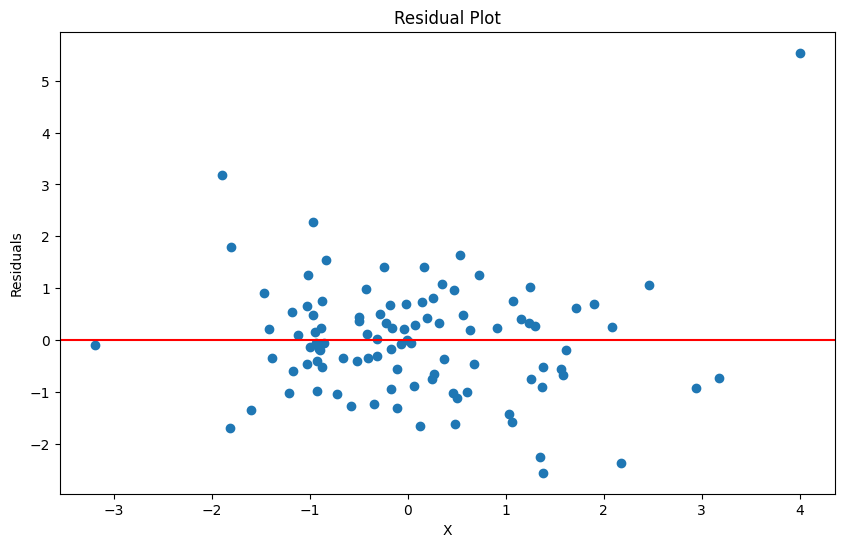

In [11]:
# plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df['residuals'])
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('X')
plt.ylabel('Residuals')
plt.show()

In [12]:
# identify potential outliers (residuals > 2 standard deviations)
residual_threshold = 2 * df['residuals'].std()
potential_outliers = df[df['abs_residuals'] > residual_threshold]

In [13]:
print(f"Potential outliers based on residuals (> {residual_threshold:.2f})")
print(potential_outliers)

Potential outliers based on residuals (> 2.25)
            X          y  residuals  abs_residuals
39  -1.894286  -0.777147   3.177157       3.177157
73   2.175326   6.393278  -2.367487       2.367487
77  -0.967393   1.219424   2.277751       2.277751
91   1.376768   3.711158  -2.554596       2.554596
100  4.000000  20.000000   5.538237       5.538237


### Leverage

In [14]:
# calculate leverage
df['leverage'] = model.get_influence().hat_matrix_diag

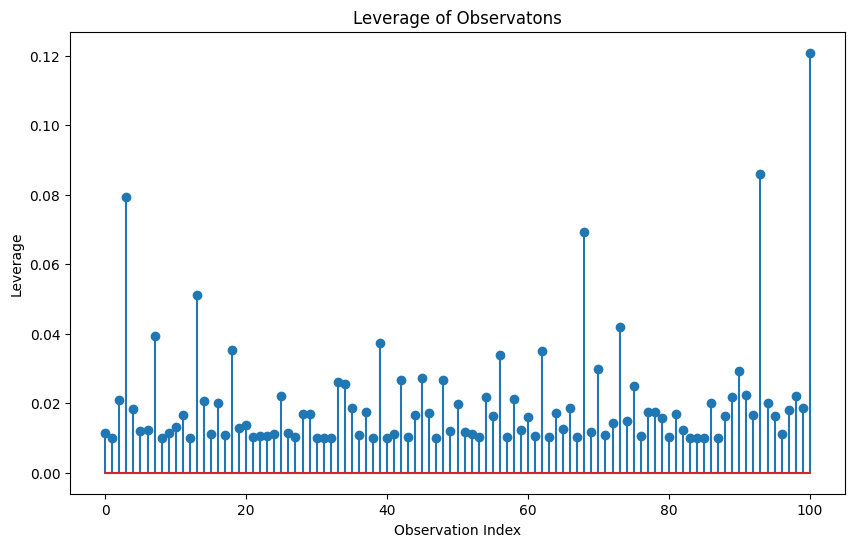

In [15]:
# plot leverage values
plt.figure(figsize=(10, 6))
plt.stem(df.index, df['leverage'])
plt.title('Leverage of Observatons')
plt.xlabel('Observation Index')
plt.ylabel('Leverage')
plt.show()

In [16]:
# indentify high leverage points (rule of thumb: leverage > 2(p+1)/n)
p = X_with_const.shape[1] - 1 # number of predictions (excluding constant)
leverage_threshold = 2 * (p + 1) / len(df)
high_leverage = df[df['leverage'] > leverage_threshold]

In [17]:
print(f"High leverage points (leverage > {leverage_threshold:.4f}):")
print(high_leverage)

High leverage points (leverage > 0.0396):
            X          y  residuals  abs_residuals  leverage
3    3.175843  11.148419  -0.738354       0.738354  0.079227
13   2.465132  10.730188   1.063957       1.063957  0.051166
68   2.942301  10.232813  -0.924283       0.924283  0.069208
73   2.175326   6.393278  -2.367487       2.367487  0.041801
93  -3.194049  -8.115416  -0.100142       0.100142  0.086021
100  4.000000  20.000000   5.538237       5.538237  0.120831


### Cook's Distance

In [18]:
# calculate cook's distance
influence = model.get_influence()
cook = influence.cooks_distance[0]
df['cooks_d'] = cook

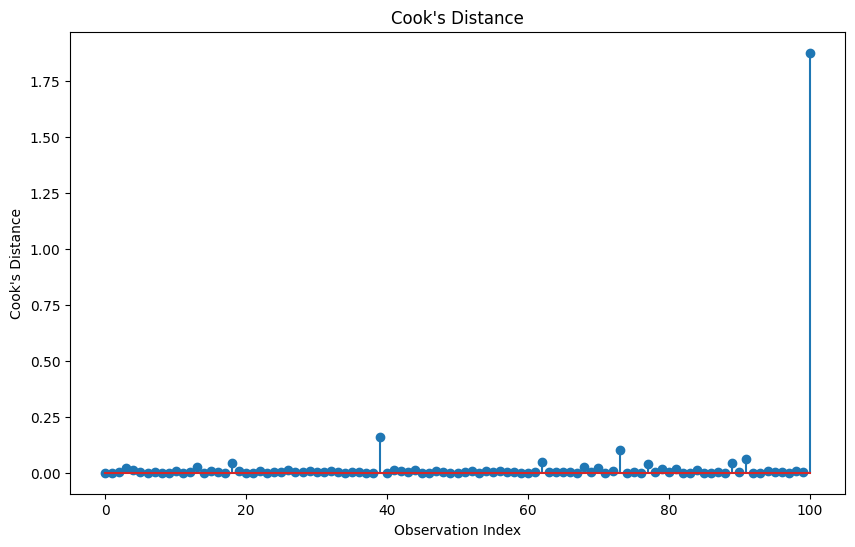

In [19]:
# plot cook's distance
plt.figure(figsize=(10, 6))
plt.stem(df.index, df['cooks_d'])
plt.title("Cook's Distance")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.show()

In [20]:
# identify influential points (rule of thumb: Cook's D > 4/n)
cooks_threshold = 4 / len(df)
influential_points = df[df['cooks_d'] > cooks_threshold]

In [21]:
print(f"Influential points (Cook's D > {cooks_threshold:.4f})")
print(influential_points)

Influential points (Cook's D > 0.0396)
            X          y  residuals  abs_residuals  leverage   cooks_d
18  -1.815033  -5.392434  -1.685748       1.685748  0.035236  0.042120
39  -1.894286  -0.777147   3.177157       3.177157  0.037416  0.159596
62  -1.803460  -1.877777   1.792752       1.792752  0.034925  0.047186
73   2.175326   6.393278  -2.367487       2.367487  0.041801  0.099912
89   1.354768   3.952180  -2.244838       2.244838  0.021814  0.044981
91   1.376768   3.711158  -2.554596       2.554596  0.022224  0.059396
100  4.000000  20.000000   5.538237       5.538237  0.120831  1.877317


### DFITS and DFBETAS

In [22]:
# calculate DFITS
df["dfits"] = influence.dffits[0]

In [23]:
# calculate DFBETAS
dfbetas = influence.dfbetas
df['dfbetas_const'] = dfbetas[:, 0]
df['dfbetas_X'] = dfbetas[:, 1]

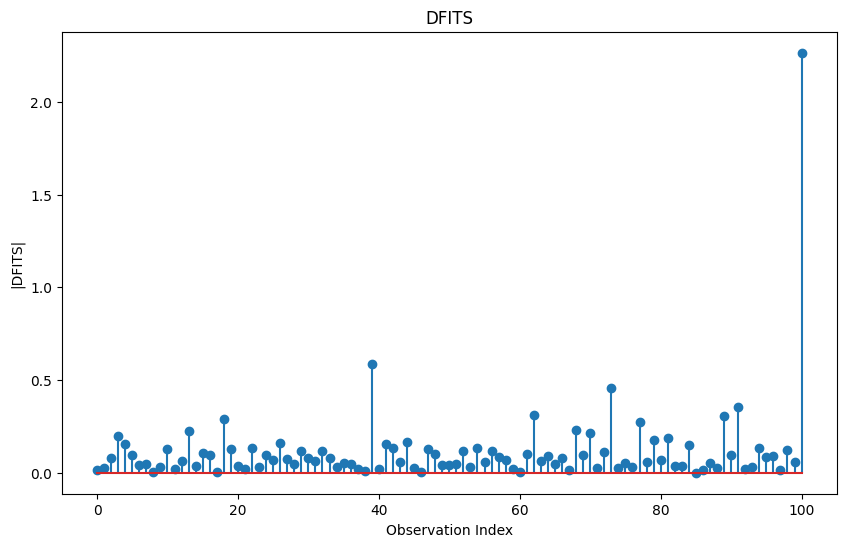

In [24]:
# plot dfits
plt.figure(figsize=(10, 6))
plt.stem(df.index, np.abs(df['dfits']))
plt.title('DFITS')
plt.xlabel('Observation Index')
plt.ylabel('|DFITS|')
plt.show()

In [25]:
# identify influential points based on DFITS (rule of thumb: |DFITS| > 2 * sqrt(p/n))
dfits_threshold = 2 * np.sqrt((p + 1) / len(df))
dfits_influential = df[np.abs(df["dfits"]) > dfits_threshold]

In [26]:
print(f"Influential points based on DFITS (|DFITS| > {dfits_threshold:.4f}):")
print(dfits_influential)

Influential points based on DFITS (|DFITS| > 0.2814):
            X          y  residuals  abs_residuals  leverage   cooks_d  \
18  -1.815033  -5.392434  -1.685748       1.685748  0.035236  0.042120   
39  -1.894286  -0.777147   3.177157       3.177157  0.037416  0.159596   
62  -1.803460  -1.877777   1.792752       1.792752  0.034925  0.047186   
73   2.175326   6.393278  -2.367487       2.367487  0.041801  0.099912   
89   1.354768   3.952180  -2.244838       2.244838  0.021814  0.044981   
91   1.376768   3.711158  -2.554596       2.554596  0.022224  0.059396   
100  4.000000  20.000000   5.538237       5.538237  0.120831  1.877317   

        dfits  dfbetas_const  dfbetas_X  
18  -0.292195      -0.168399   0.247765  
39   0.586981       0.329415  -0.503362  
62   0.309752       0.179220  -0.262194  
73  -0.455413      -0.199223  -0.397839  
89  -0.304691      -0.192460  -0.225167  
91  -0.352343      -0.220254  -0.262371  
100  2.265658       0.527093   2.170850  


### Influence Plot

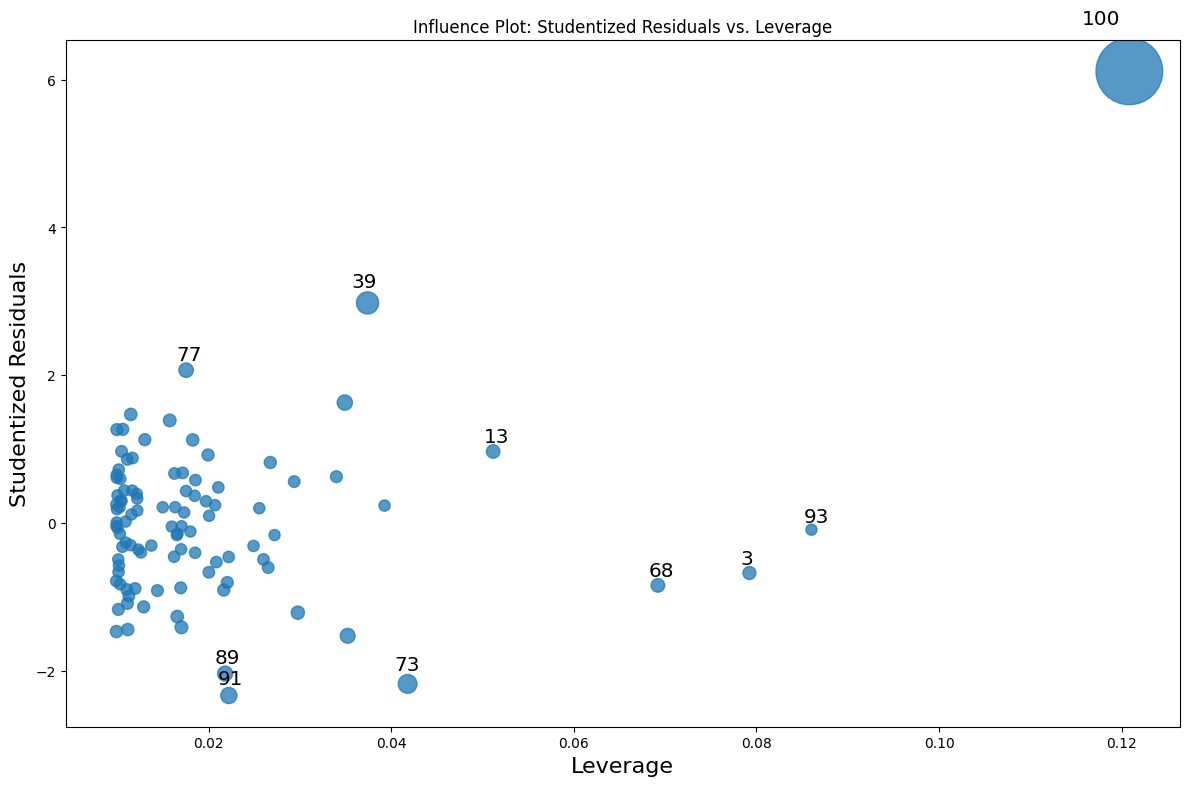

In [27]:
# create influence plot
fig, ax = plt.subplots(figsize=(12, 8))
influence_plot(model, ax=ax)
plt.title("Influence Plot: Studentized Residuals vs. Leverage")
plt.tight_layout()
plt.show()

### Handling Influential Observations

In [31]:
# Fit model without the influential point
clean_df = df[df.index != 100]
X_clean = sm.add_constant(clean_df["X"])
clean_model = sm.OLS(clean_df['y'], X_clean).fit()

In [33]:
# compare models
print("Original Model:")
print(f"Intercept: {model.params[0]:.4f}, Slope: {model.params[1]:.4f}, R-squared {model.rsquared:.4f}")

print("\nModel without influential point:")
print(f"Intercept: {clean_model.params[0]:.4f}, Slope: {clean_model.params[1]:.4f}. R-squared {clean_model.rsquared:.4f}")

Original Model:
Intercept: 1.9642, Slope: 3.1244, R-squared 0.9151

Model without influential point:
Intercept: 1.9134, Slope: 2.9468. R-squared 0.9216


C:\Users\riain\AppData\Local\Temp\ipykernel_23376\1828462230.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {model.params[0]:.4f}, Slope: {model.params[1]:.4f}, R-squared {model.rsquared:.4f}")
C:\Users\riain\AppData\Local\Temp\ipykernel_23376\1828462230.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept: {clean_model.params[0]:.4f}, Slope: {clean_model.params[1]:.4f}. R-squared {clean_model.rsquared:.4f}")


C:\Users\riain\AppData\Local\Temp\ipykernel_23376\604612429.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, model.params[0] + model.params[1] * x_range, 'b-', label=f'Original Model: y = {model.params[0]:.2f} + {model.params[1]:.2f}X')
C:\Users\riain\AppData\Local\Temp\ipykernel_23376\604612429.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(x_range, clean_model.params[0] + clean_model.params[1] * x_range, 'g--', label=f'Clean Model: y = {clean_model.params[0]:.2f} + {clean_model.params[1]:.2f}X')


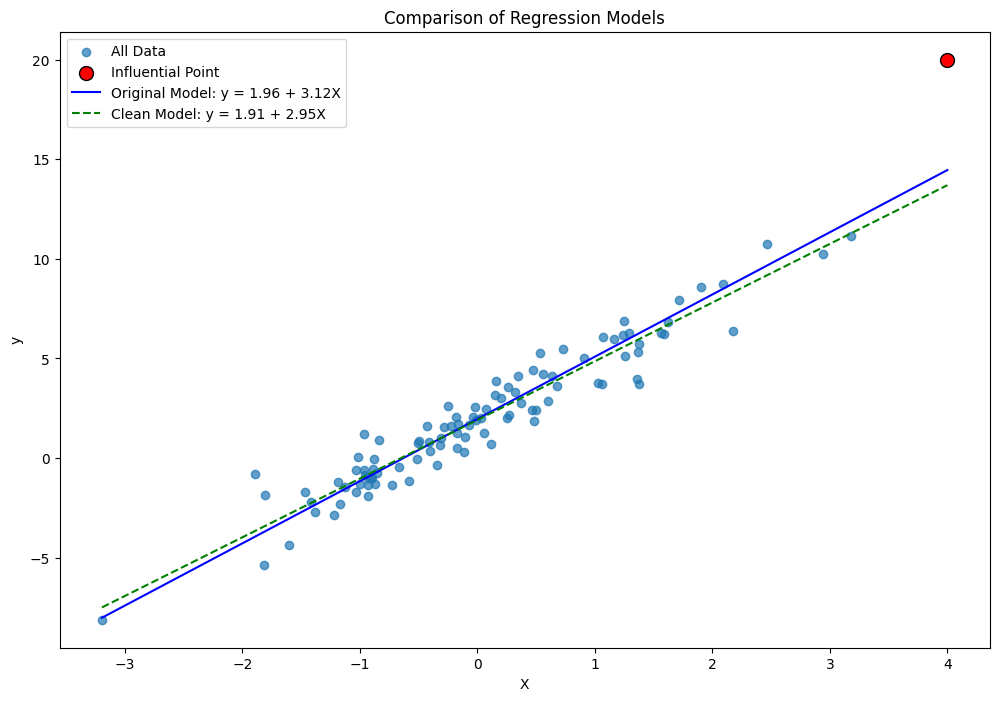

In [34]:
# Plot comparison
plt.figure(figsize=(12, 8))

# plot original data
plt.scatter(df['X'], df['y'], alpha=0.7, label='All Data')

# highlight influential point
plt.scatter(df.loc[100, 'X'], df.loc[100, 'y'], color='red', s=100, label="Influential Point", edgecolor='black')

# plot original regression line
x_range = np.linspace(df['X'].min(), df['X'].max(), 100)
plt.plot(x_range, model.params[0] + model.params[1] * x_range, 'b-', label=f'Original Model: y = {model.params[0]:.2f} + {model.params[1]:.2f}X')

# plot clean regression line
plt.plot(x_range, clean_model.params[0] + clean_model.params[1] * x_range, 'g--', label=f'Clean Model: y = {clean_model.params[0]:.2f} + {clean_model.params[1]:.2f}X')

plt.title("Comparison of Regression Models")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()